# Analysing Samsung Internal SSD Reviews
Name: Abdulrahman ALQannas

Data source: https://www.kaggle.com/abdulrahmanalqannas/ssd-reviews

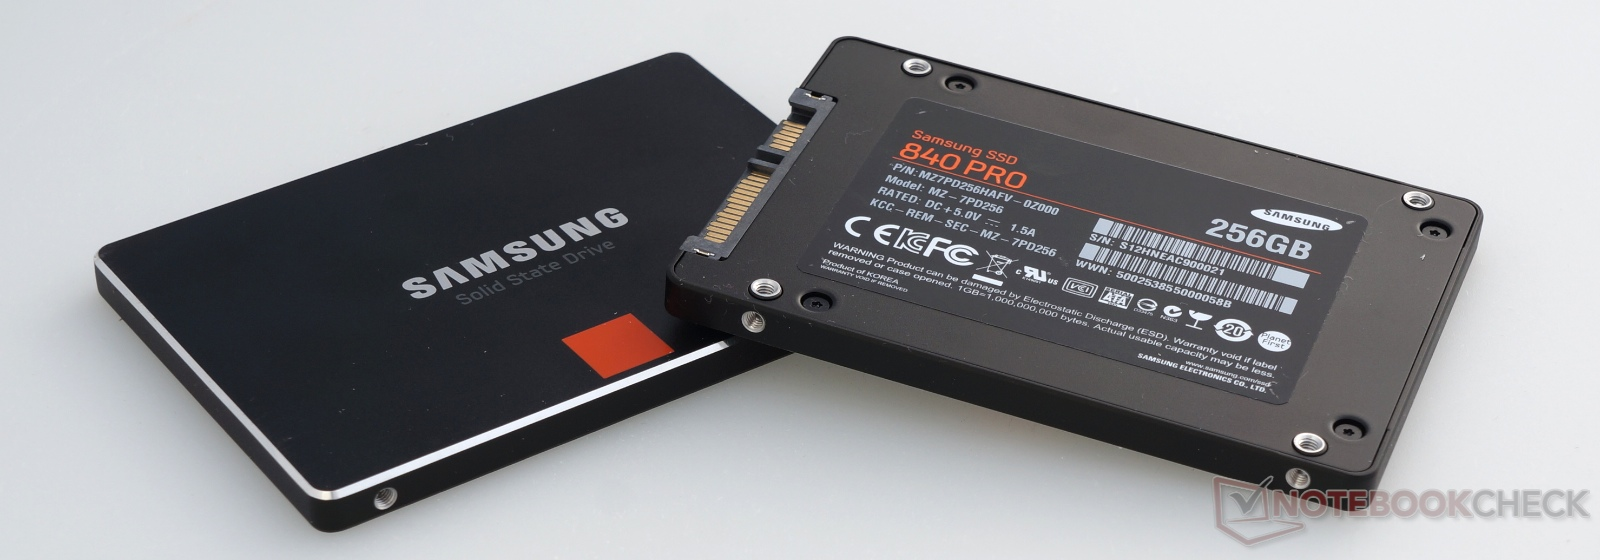

## Problem statement

Here we were provided with a dataset of Samsung internal ssd customers reviews, And we will try to understand if the customer is happy or not by doing sentiment analysis to the customers reviews.<br><br><br>

In [223]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
#sklearn
from sklearn.model_selection import KFold, train_test_split, cross_val_score
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer, TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB, GaussianNB
from sklearn import metrics, svm
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix
from sklearn.neighbors import KNeighborsClassifier 
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier



# To ignore unwanted warnings
import warnings
warnings.filterwarnings('ignore')

In [224]:
df = pd.read_csv('data/ssd_reviews.csv', index_col=0)

## Data Exploratory

In [225]:
df.head()

,review_title,overall_review,pros,cons,ownership_pariod,date,rating_stars,year,month,day
0,solid,buy it you will not regret this purchase,reliable fast silent cool running drive highly...,NaN,years,2019-12-05 12:58:58,5,2019,12,5
1,nice drive for price even cheaper by todays costs,good drive price,been running almost constantly since when i pu...,NaN,years,2019-11-01 08:25:45,5,2019,11,1
2,perfect,used this drive as my boot drive and only data...,good value decently fast good longevity,none so far,years,2019-10-27 17:05:49,5,2019,10,27
3,very snappy,os boots quicker os menus pop up quicker gamin...,noticeable improvement in os performance over ...,samsung magician software causes some games to...,years,2019-10-24 18:29:43,5,2019,10,24
4,worth the hype,this was the sdd that everyone said to get and...,NaN,NaN,years,2019-09-11 19:21:03,5,2019,9,11


In [226]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2227 entries, 0 to 2226
Data columns (total 10 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   review_title      2131 non-null   object
 1   overall_review    1448 non-null   object
 2   pros              2205 non-null   object
 3   cons              2216 non-null   object
 4   ownership_pariod  2159 non-null   object
 5   date              2227 non-null   object
 6   rating_stars      2227 non-null   int64 
 7   year              2227 non-null   int64 
 8   month             2227 non-null   int64 
 9   day               2227 non-null   int64 
dtypes: int64(4), object(6)
memory usage: 191.4+ KB


#### Number of null values in each column

We can see below that overall_review column has a lot of null values, Also we can see that we have 2 columns called 'pros' and 'cons' and they are almost has no null values, So in the feature engineering section I will explain how we can benefit from that

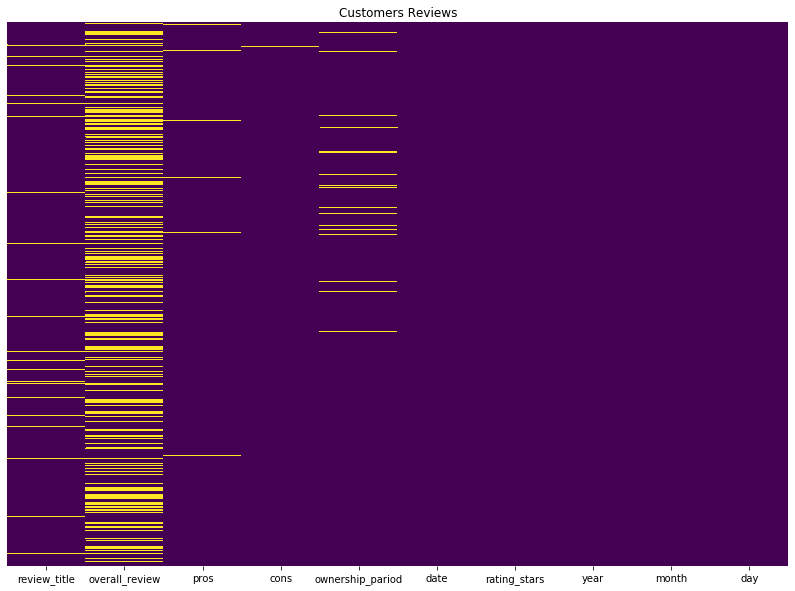

In [227]:
fig, ax = plt.subplots(figsize = (14, 10))
sns.heatmap(df.isnull(), yticklabels=False, ax = ax, cbar=False, cmap='viridis')
ax.set_title('Customers Reviews')
plt.show()

In [228]:
df['date'] = pd.to_datetime(df['date'])

In [229]:
df['rating_stars'].value_counts()

5    1756
4     181
1     153
3      77
2      60
Name: rating_stars, dtype: int64

**Looks like the product doing very well!, The most majority of customers rated the product with 5 stars, And this might be a problem in normal cases because the sentiment analysis model will be bias to the good reviews, Why? because they are above 80% of our data, But like I said this is in a normal case scenario,<br><br>
The good thing here that we can do a simple trick to fix this problem also this trick will double our data, Intresting yes? Alright to discover this trick look at the feature engineering part.**

## Feature Engineering

#### Trick explaining

We saw before how the 'overall_review' column missing a lot of data, So we can't use it and expect a good result.<br>
What we will do insted is merging 'pros' column with 'cons' column to be in a single column, And what I meeant be merging them is by creating a new column called "pros_and_cons" in a new dataframe and create another column with this column called positive, which will contain 0 and 1, The value will be 1 if the row in "pros_and_cons" column contains pros, And will contain 0 if the row in "pros_and_cons" column contains cons<br>

And how this is will double our data? by puting 'cons' column under 'pros' column in our new column "pros_and_cons", so it will be 4000 row insted of 2000 row.

#### Merging 'pros' and cons in one column in a new dataframe

Prepare cons before merging

In [230]:
df_cons = df[['cons']].dropna()
df_cons['positive'] = 0

Below we are droping any row contains ('none', 'none so far', 'non') because these are not cons, So basicly what the customer meant by writing 'none' here in 'cons' that there is no cons

In [231]:
# a lot of values droped around 700 row in cons
df_cons.drop(df_cons[df_cons['cons'].isin(['none', 'none so far', 'non'])].index, inplace=True)

In [232]:
df_cons.rename(columns={'cons':'pros_and_cons'}, inplace=True)

Prepare pros before merging

In [233]:
#To make our data balanced betwwen'pros' and 'cons', Here in 'pros' we took only 1562 row because a lot of rows droped in 'cons'
df_pros = df[['pros']][:1562].dropna()

In [234]:
df_pros.rename(columns={'pros':'pros_and_cons'}, inplace=True)

In [235]:
df_pros['positive'] = 1

Merging 'pros' and 'cons'

In [236]:
merged_df = pd.merge(left=df_pros, right=df_cons, left_on=['pros_and_cons', 'positive'],
                     right_on=['pros_and_cons', 'positive'], how='outer')

And here our final data before modeling

In [237]:
merged_df

,pros_and_cons,positive
0,reliable fast silent cool running drive highly...,1
1,reliable fast silent cool running drive highly...,1
2,been running almost constantly since when i pu...,1
3,been running almost constantly since when i pu...,1
4,good value decently fast good longevity,1
...,...,...
3104,not much yet only time will tell,0
3105,no sata to usb cable the most important cable ...,0
3106,product description could be better vertical r...,0
3107,the packaging is very barebones and only inclu...,0


We can see below our data now balanced

In [238]:
merged_df['positive'].value_counts()

0    1562
1    1547
Name: positive, dtype: int64

## Modeling

In [239]:
X = merged_df.drop('positive', axis=1)
y = merged_df['positive']

In [240]:
bow_f = CountVectorizer(stop_words='english').fit(X['pros_and_cons'])

In [241]:
print("After eliminating stop words: ", len(bow_f.get_feature_names()))

After eliminating stop words:  5426


In [242]:
bow_transform = bow_f.transform(X['pros_and_cons'])

In [243]:
count_vect_df = pd.DataFrame(bow_transform.todense(), columns=bow_f.get_feature_names())
np.sum(count_vect_df).sort_values(ascending=False)[0:20]

drive       1043
ssd          874
fast         811
samsung      648
software     574
windows      346
price        332
great        323
install      307
easy         279
boot         270
10           268
time         266
just         241
sata         241
good         229
use          225
old          217
faster       211
new          200
dtype: int64

In [244]:
X_train, X_test, y_train, y_test = train_test_split(bow_transform, y, test_size=0.3, random_state=42)

In [245]:
#8
logreg = LogisticRegression()
logreg.fit(X_train, y_train)
print('train score' , logreg.score(X_train, y_train))
print('test score' , logreg.score(X_test, y_test))
y_pred = logreg.predict(X_test)

train score 0.9595588235294118
test score 0.8478027867095391


In [246]:
confusion_matrix(y_test, y_pred)

array([[393,  47],
       [ 95, 398]], dtype=int64)

### TF-IDF
Let's see if TF-IDF improves the accuracy.

In [247]:
tfidf_vectoriser = TfidfVectorizer(stop_words='english')
tfidf_f = tfidf_vectoriser.fit(X['pros_and_cons'])
tfidf_transform = tfidf_f.transform(X['pros_and_cons'])

In [248]:
tf_X_train, tf_X_test, y_train, y_test = train_test_split(tfidf_transform, y, test_size=0.3)

In [448]:
tf_logreg = LogisticRegression(C=3.2)
tf_logreg.fit(tf_X_train, y_train)
print('train score' , tf_logreg.score(tf_X_train, y_train))
print('test score' , tf_logreg.score(tf_X_test, y_test))

y_pred = tf_logreg.predict(tf_X_test)

train score 0.9673713235294118
test score 0.879957127545552


In [449]:
cv=KFold(n_splits=5, shuffle=True, random_state=1)
cross_val_score(tf_logreg, tfidf_transform, y, cv=cv).mean()

0.8752033593778317

In [450]:
confusion_matrix(y_test, y_pred)

array([[434,  43],
       [ 69, 387]], dtype=int64)

In [451]:
knn_classifier = KNeighborsClassifier()  
knn_classifier.fit(tf_X_train, y_train)
print(knn_classifier.score(tf_X_train, y_train))
print (knn_classifier.score(tf_X_test, y_test))
y_pred = knn_classifier.predict(tf_X_test)

0.5960477941176471
0.5894962486602358


In [452]:
confusion_matrix(y_test, y_pred)

array([[473,   4],
       [379,  77]], dtype=int64)

In [453]:
tree= DecisionTreeClassifier()
tree.fit(tf_X_train, y_train)
print('test score' , tree.score(tf_X_train, y_train))
print('test score' , tree.score(tf_X_test, y_test))
y_pred = tree.predict(tf_X_test)

test score 0.9954044117647058
test score 0.8081457663451233


In [454]:
confusion_matrix(y_test, y_pred)

array([[378,  99],
       [ 80, 376]], dtype=int64)

In [455]:
svm_linear = svm.SVC(kernel='linear')
svm_linear.fit(tf_X_train, y_train)
print('Train : ', svm_linear.score(tf_X_train, y_train))
print('Test: ', svm_linear.score(tf_X_test, y_test))
y_pred = svm_linear.predict(tf_X_test)

Train :  0.9600183823529411
Test:  0.8767416934619507


In [456]:
confusion_matrix(y_test, y_pred)

array([[433,  44],
       [ 71, 385]], dtype=int64)

In [457]:
cv=KFold(n_splits=5, shuffle=True, random_state=1)
cross_val_score(svm_linear, tfidf_transform, y, cv=cv).mean()

0.8678052720692172

##### <span style="color:blue">The Support Vector Machine(svm) result is the best</span>

In [478]:
svm_rbf = svm.SVC(kernel='rbf',C=1, probability=True)
svm_rbf.fit(tf_X_train, y_train)
print('Train : ', svm_rbf.score(tf_X_train, y_train))
print('Test: ', svm_rbf.score(tf_X_test, y_test))
y_pred = svm_rbf.predict(tf_X_test)

Train :  0.9839154411764706
Test:  0.8853161843515541


In [479]:
cv=KFold(n_splits=5, shuffle=True, random_state=1)
cross_val_score(svm_rbf, tfidf_transform, y, cv=cv).mean()

0.8825988577701146

In [480]:
confusion_matrix(y_test, y_pred)

array([[436,  41],
       [ 66, 390]], dtype=int64)

In [461]:
svm_poly = svm.SVC(kernel='poly', C=.7)
svm_poly.fit(tf_X_train, y_train)
print('Train : ', svm_poly.score(tf_X_train, y_train))
print('Test: ', svm_poly.score(tf_X_test, y_test))
y_pred = svm_poly.predict(tf_X_test)

Train :  0.9926470588235294
Test:  0.8703108252947481


In [462]:
cv=KFold(n_splits=5, shuffle=True, random_state=1)
cross_val_score(svm_poly, tfidf_transform, y, cv=cv).mean()

0.8021632984865195

In [463]:
confusion_matrix(y_test, y_pred)

array([[414,  63],
       [ 58, 398]], dtype=int64)

In [465]:
randomF = RandomForestClassifier()
randomF.fit(tf_X_train, y_train)
print('Train score :',randomF.score(tf_X_train, y_train))
print('Ttest score :',randomF.score(tf_X_test, y_test))
y_pred = randomF.predict(tf_X_test)

Train score : 0.9954044117647058
Ttest score : 0.8638799571275455


In [347]:
cv=KFold(n_splits=5, shuffle=True, random_state=1)
cross_val_score(randomF, tfidf_transform, y, cv=cv).mean()

0.8703812438189622

In [466]:
confusion_matrix(y_test, y_pred)

array([[415,  62],
       [ 65, 391]], dtype=int64)

In [467]:
gnb = GaussianNB(var_smoothing=0.11) 
gnb.fit(tf_X_train.toarray(), y_train) 
print('Train score :',gnb.score(tf_X_train.toarray(), y_train))
print('Ttest score :',gnb.score(tf_X_test.toarray(), y_test))
y_pred = gnb.predict(tf_X_test.toarray())

Train score : 0.9250919117647058
Ttest score : 0.8542336548767417


In [468]:
confusion_matrix(y_test, y_pred)

array([[429,  48],
       [ 88, 368]], dtype=int64)

In [469]:
cv=KFold(n_splits=5, shuffle=True, random_state=1)
cross_val_score(gnb, tfidf_transform.toarray(), y, cv=cv).mean()

0.8517260305181458

In [470]:
mnb = MultinomialNB(alpha=0.22) 
mnb.fit(tf_X_train.toarray(), y_train) 
print('Train score :',mnb.score(tf_X_train.toarray(), y_train))
print('Ttest score :',mnb.score(tf_X_test.toarray(), y_test))
y_pred = mnb.predict(tf_X_test.toarray())

Train score : 0.9191176470588235
Ttest score : 0.8370846730975349


In [471]:
confusion_matrix(y_test, y_pred)

array([[368, 109],
       [ 43, 413]], dtype=int64)

<b>Test manually</b>

In [512]:
tfidf_comments = tfidf_f.transform(['expensive'])
svm_rbf.predict(tfidf_comments)
round(svm_rbf.predict_proba(tfidf_comments)[0][1], 5)

0.00491

## Conclusion
After we analysed Samsung internal ssd customers reviews, And after we build a sentiment analysis model, And after we test our model with cross validation We got the following:<br>
- Our model can classifie any new ssd review with 88% Accuracy

<br>
And finally after we test a lot of models the model we chose to be the best model in this case is: The Support Vector Machine(svm) with 'rbf' kernal.

I hope you enjoyed reading this notebook, Have a great day.